# Count Number of Empty Car Parking Lots

#### Team : sesh
> Smruti Biswal
>
> Eshika Khandelwal
>
> Srujana Vanka
>
> Shreeya Singh 

### Importing Libraries

In [38]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from collections import deque
import os

## Detection using two images - occupied and empty

### Step by step

- load the images, convert **BGR to RGB** and **resize** the occupied image to match the size of the unoccupied image

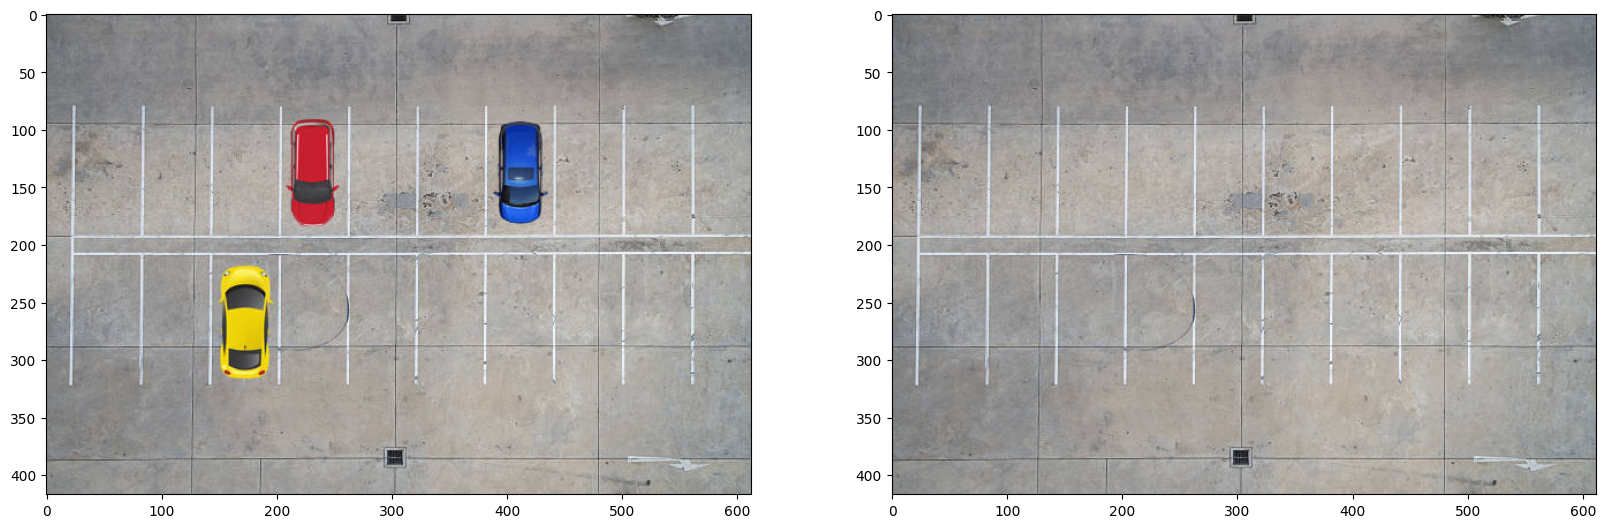

In [39]:
src_occupied = cv2.imread('../data/inputs/occupied2.2.jpg')
src_unoccupied = cv2.imread('../data/inputs/empty2.jpeg')
# resizing the occupied image to match the unoccupied image
src_occupied = cv2.resize(src_occupied, (src_unoccupied.shape[1], src_unoccupied.shape[0]))
src_unoccupied = cv2.cvtColor(src_unoccupied, cv2.COLOR_BGR2RGB )
src_occupied = cv2.cvtColor(src_occupied, cv2.COLOR_BGR2RGB )
plt.figure(figsize = (20,10))
plt.subplot(121)
plt.imshow(src_occupied)
plt.subplot(122)
plt.imshow(src_unoccupied)

- convert the images to **grayscale**
- **dilating** unoccupied parking lot to emphasize the parking lot boundaries
- apply **gaussian blur** to both the images to reduce noise and smoothen the images

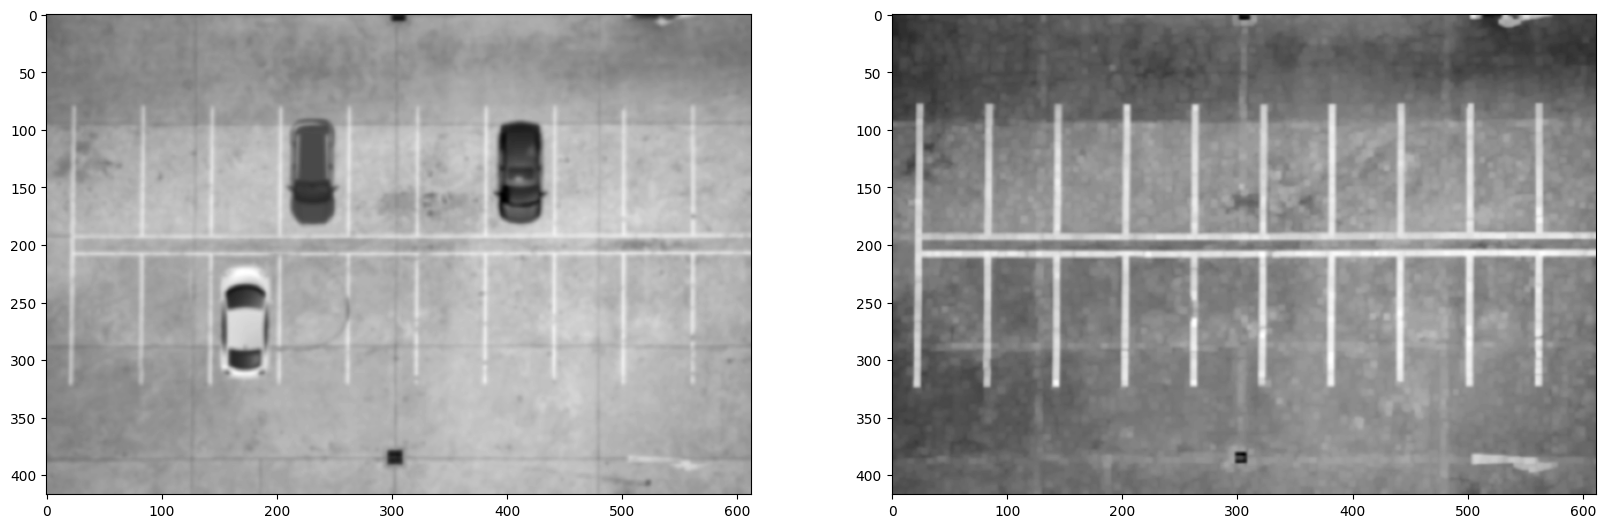

In [40]:
# grayscale images
occupied = cv2.imread('../data/inputs/occupied2.2.jpg',0)
unoccupied = cv2.imread('../data/inputs/empty2.jpeg',0)
# resizing the unoccupied image to match the occupied image
occupied = cv2.resize(occupied, (unoccupied.shape[1], unoccupied.shape[0]))

# dilating unoccupied parking lot to emphasize the parking lot boundaries
unoccupied = cv2.dilate(unoccupied, np.ones((5,5), np.uint8), iterations=1)

# Apllying Gaussian Blur
unoccupied = cv2.GaussianBlur(unoccupied,(5,5),0)
occupied = cv2.GaussianBlur(occupied,(9,9),0)

plt.figure(figsize = (20,10))
plt.subplot(121)
plt.imshow(occupied, cmap='gray')
plt.subplot(122)
plt.imshow(unoccupied, cmap='gray')

- apply thresholding to unoccupied image to convert it to **binary image**

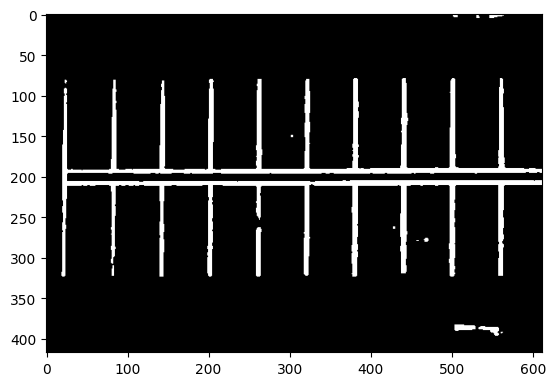

In [41]:
# convert unoccupied parking lot to binary
ret, unoccupied_bin = cv2.threshold(unoccupied, 207, 255, cv2.THRESH_BINARY)
plt.imshow(unoccupied_bin, cmap='gray')

- apply **canny edge detection** to both the images

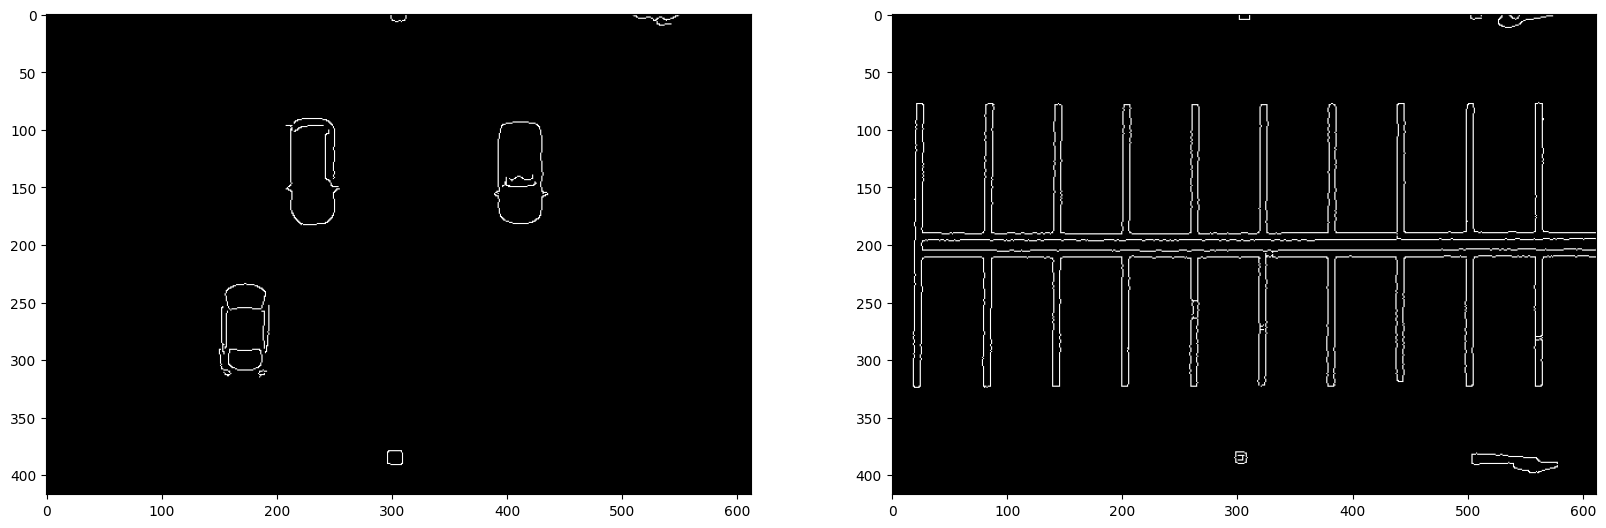

In [42]:
# canny edge detection
occupied = cv2.Canny(occupied, 50, 150)
unoccupied = cv2.Canny(unoccupied, 50, 150)

plt.figure(figsize = (20,10))
plt.subplot(121)
plt.imshow(occupied, cmap='gray')
plt.subplot(122)
plt.imshow(unoccupied, cmap='gray')

- function to detect lines in a given image using **Hough Lines**

In [43]:
def detectHoughLines(img1,img2):
    cpy = np.copy(img2)*0
    lines = cv2.HoughLinesP(img1, 1, np.pi/180, 15,np.array([]),  minLineLength=30, maxLineGap=20)
    for line in lines:
        for x1,y1,x2,y2 in line:
         cv2.line(cpy,(x1,y1),(x2,y2),(255,0,0),5)
    cpy = cv2.bitwise_or(img2, cpy)
    return cpy

- output of detected lines in the unoccupied image

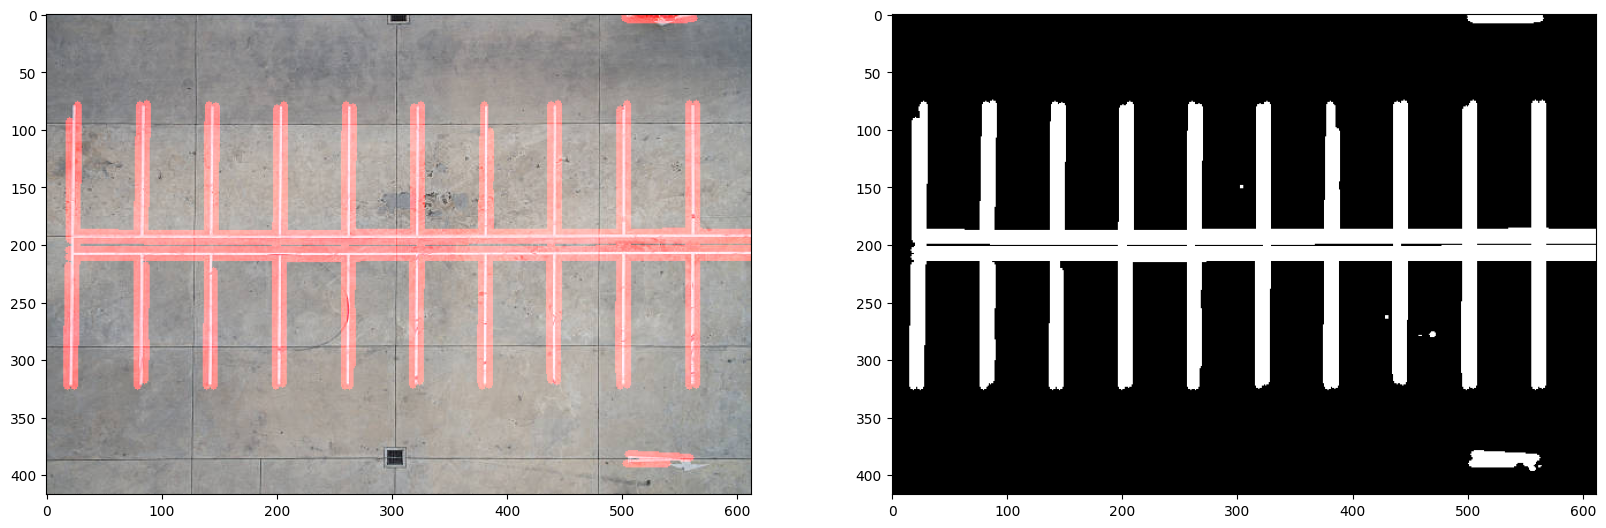

In [44]:
originalLines = detectHoughLines(unoccupied, src_unoccupied)
unoccupied_cpy = detectHoughLines(unoccupied, unoccupied_bin)
plt.figure(figsize = (20,10))
plt.subplot(121)
plt.imshow(originalLines)
plt.subplot(122)
plt.imshow(unoccupied_cpy, cmap='gray')

- function to apply **skeletonization** to the lines detected in the unoccupied image

In [45]:
elem = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
def skeletonize(img, element = elem):
    skel = np.zeros(img.shape,np.uint8)
    img = cv2.threshold(img,127,255,0)[1]
    
    while(1):
        eroded = cv2.erode(img,element)
        temp = cv2.dilate(eroded,element)
        temp = img - temp
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()
        zeros = np.size(img) - cv2.countNonZero(img)
        if zeros==np.size(img):
            break
    return skel

- to get straight lines accurately, we make use of skeletonization and detectHoughLines repeatedly

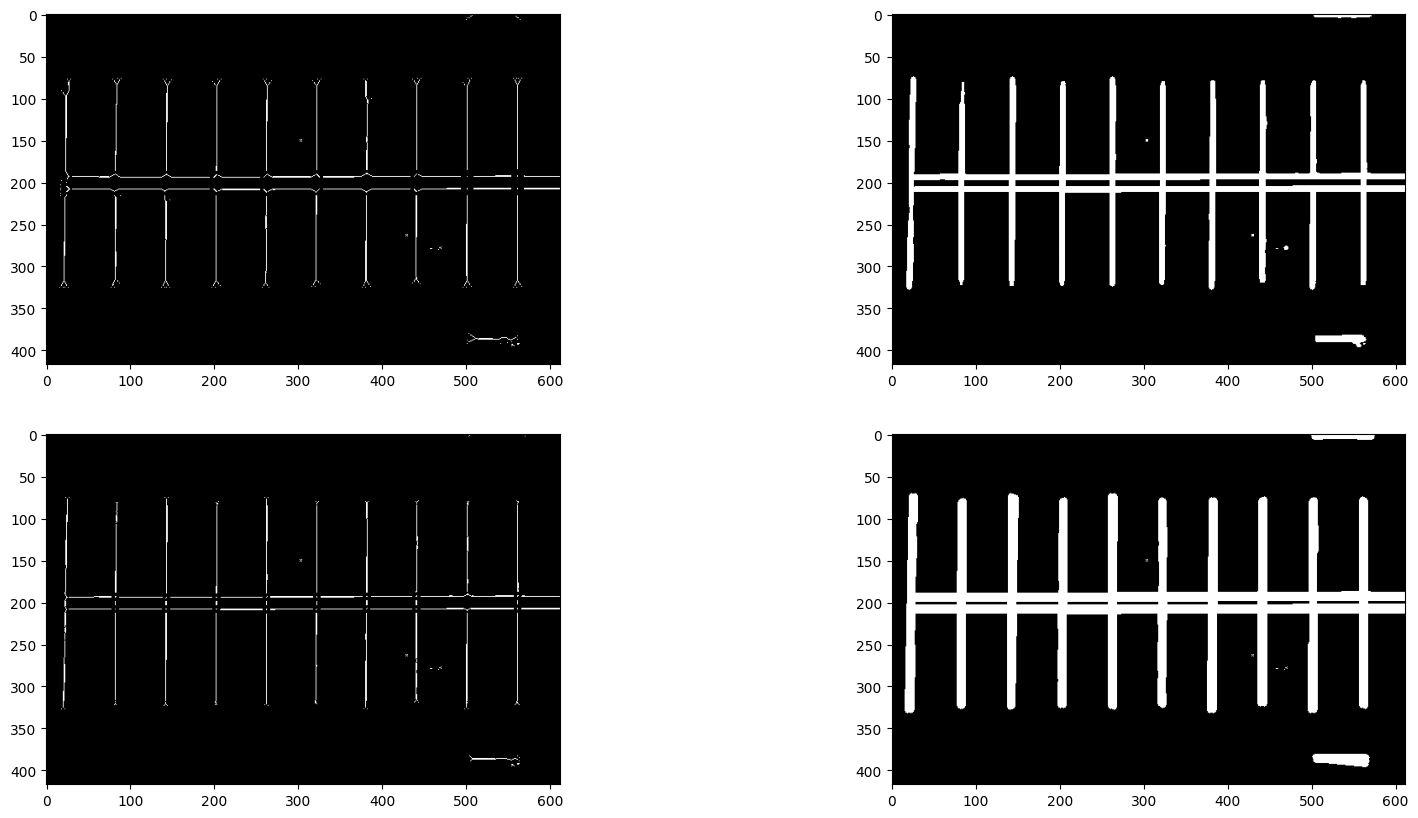

In [46]:
skel1 = skeletonize(unoccupied_cpy)

res1 = detectHoughLines(skel1, unoccupied_bin)

skel = skeletonize(res1)

cnts = cv2.findContours(skel, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
src = skel.copy()
for c in cnts:
     cv2.drawContours(src,[c], 0, (255,255,255), 3)
     
res = detectHoughLines(src, skel)
plt.figure(figsize = (20,10))
plt.subplot(221)
plt.imshow(skel1, cmap='gray')
plt.subplot(222)
plt.imshow(res1, cmap='gray')
plt.subplot(223)
plt.imshow(skel, cmap='gray')
plt.subplot(224)
plt.imshow(res, cmap='gray')

- perform **eroding** on the lines detected output and then perform skeletonization to get the **minimum lines** for a straight line

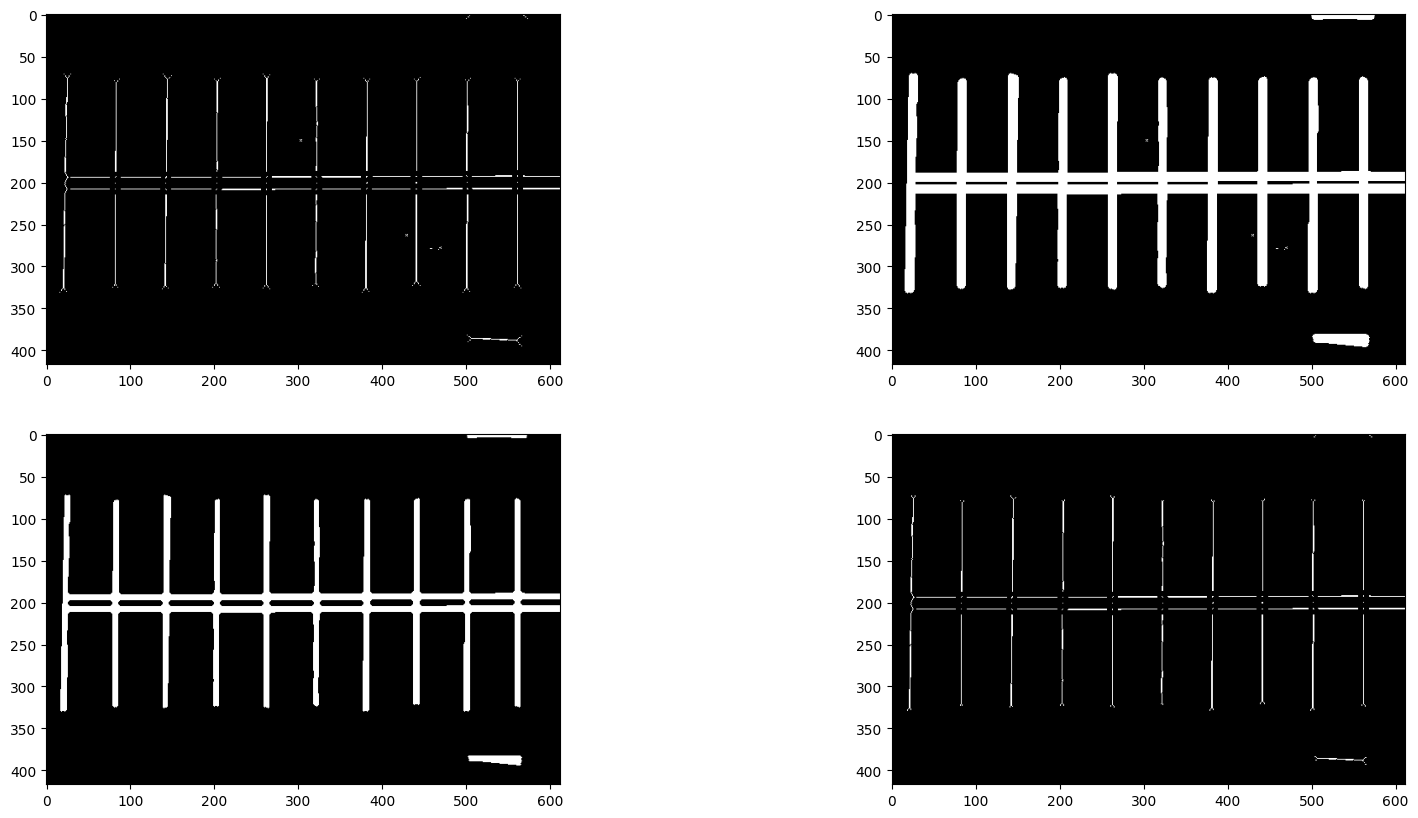

In [47]:
skel = skeletonize(res)
# plt.imshow(detectHoughLines(skel,src_unoccupied))
res = detectHoughLines(src, skel)

element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
eroded = cv2.erode(res,element)
eroded = cv2.erode(eroded,element)

plt.figure(figsize = (20,10))
plt.subplot(221)
plt.imshow(skel, cmap='gray')
plt.subplot(222)
plt.imshow(res, cmap='gray')
plt.subplot(223)
plt.imshow(eroded, cmap='gray')

skel = skeletonize(eroded)
plt.subplot(224)
plt.imshow(skel, cmap='gray')

- draw only **straight vertical lines** of the parking lot to help us detect the **center** of each parking space and **store them** in a list
- To do this we hide all the lines with slope 0. Due to this even the slanting parking lots are accommodated.

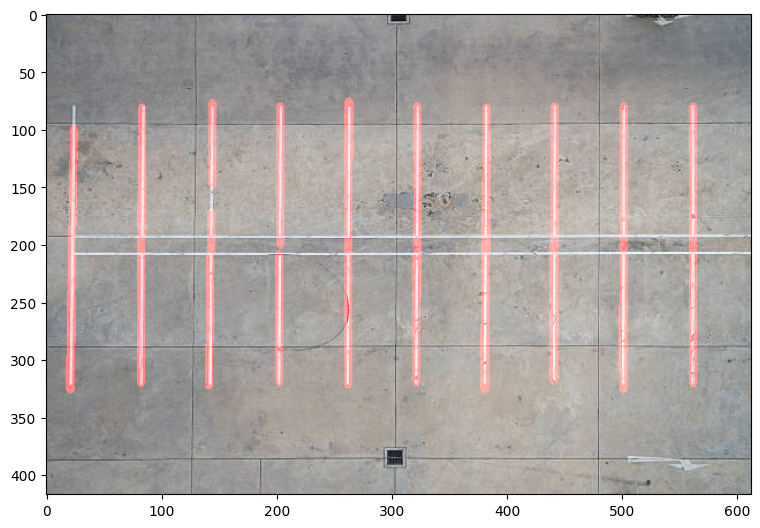

In [48]:
res = np.copy(src_unoccupied)*0
lines = cv2.HoughLinesP(skel, 1, np.pi/180, 15,np.array([]),  minLineLength=30, maxLineGap=20)
vertical = {}
height = 0
for line in lines:
    for x1,y1,x2,y2 in line:
      if abs(y2-y1)>50 :
        cv2.line(res,(x1,y1),(x2,y2),(255,0,0),5)
        if(abs(x1-x2)<4): 
          vertical[str(x1)] = [y1, y2]
          height = max(abs(y1-y2), height)

res = cv2.bitwise_or(src_unoccupied, res)
plt.figure(figsize = (20,10))
plt.subplot(121)
plt.imshow(res)

- function to find the **coordinates of the center** of each parking space

In [49]:
def findPKLots(skel, src_unoccupied):
    lines = cv2.HoughLinesP(skel, 1, np.pi/180, 15,np.array([]),  minLineLength=30, maxLineGap=20)
    vertical = {}
    height = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
          if abs(y2-y1)>50 :
            if(abs(x1-x2)<6): 
              vertical[str(x1)] = [y1, y2]
              height = max(abs(y1-y2), height)
    
    keys = []
    for key in vertical.keys():
        keys.append(int(key))
    keys.sort()
    i = 1
    while(i!=len(keys)):
        if(abs(keys[i]-keys[i-1])<5):
            keys.remove(keys[i])
        else: i = i+1

    coordinates = []
    img_height = src_unoccupied.shape[0]
    y1 = img_height/2 - height/4
    y2 = img_height/2 + height/4
    for i in range(len(keys)-1):
        x = keys[i] + (keys[i+1]-keys[i])/2
        coordinates.append([x, y1])
        coordinates.append([x, y2])
    print(len(coordinates))
    return coordinates


- output of the coordinates of the center of each parking space in the unoccupied parking lot

In [50]:
findPKLots(skel, src_unoccupied)

18


[[51.0, 147.0],
 [51.0, 270.0],
 [111.5, 147.0],
 [111.5, 270.0],
 [171.5, 147.0],
 [171.5, 270.0],
 [232.0, 147.0],
 [232.0, 270.0],
 [291.5, 147.0],
 [291.5, 270.0],
 [350.5, 147.0],
 [350.5, 270.0],
 [410.0, 147.0],
 [410.0, 270.0],
 [470.0, 147.0],
 [470.0, 270.0],
 [530.5, 147.0],
 [530.5, 270.0]]

- performing **closing** on the occupied image to fill in the holes in the occupied parking spaces and thresholding the image.
- making use of **```floodFill```** to fill in the holes in the occupied parking spaces and then **inverting** the output to get the car represented as white pixels and the background as black pixels 

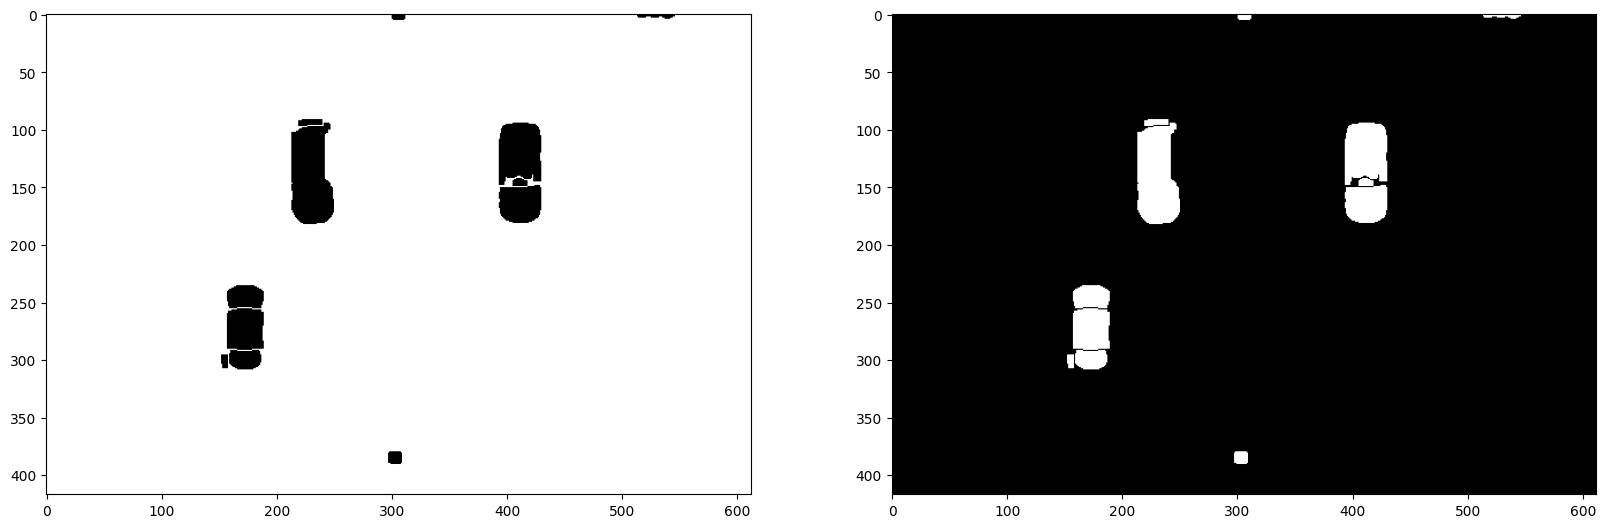

In [51]:
kernel = np.ones((5,5),np.uint8)
# closing the image to fill the gaps
closing = cv2.morphologyEx(occupied, cv2.MORPH_CLOSE, kernel)
# thresholding the image
thresh = cv2.threshold(closing, 127, 255, cv2.THRESH_BINARY)[1]

im_floodfill = thresh.copy()
h, w = thresh.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
# floodfilling remaining gaps
plt.figure(figsize = (20,10))
cv2.floodFill(im_floodfill, mask, (0,0), 255)
plt.subplot(121)
plt.imshow(im_floodfill, cmap='gray')
# inverting the image
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
plt.subplot(122)
plt.imshow(im_floodfill_inv, cmap='gray')

- overlaying the extracted images of cars on the unoccupied parking lot image to get the **final output** using **```Bitwise_or```**

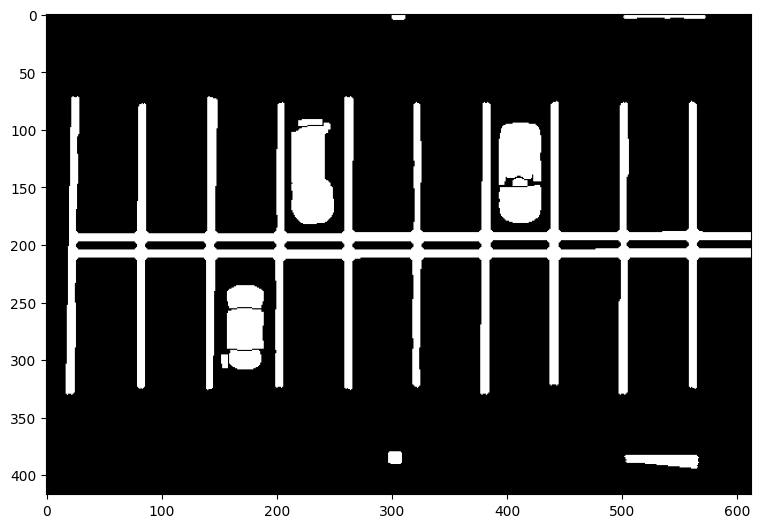

In [52]:
# bitwise or of the two images
result = cv2.bitwise_or(im_floodfill_inv, eroded)
plt.figure(figsize = (20,10))
plt.subplot(121)
plt.imshow(result, cmap='gray')

## Count Cars

- function to count all pixels in a **connected component** using **```BFS```** algorithm

In [53]:
def validate(x, y, image, visited):
    # Check if position of pixel is inside image
    if x < 0 or x >= image.shape[0] or y < 0 or y >= image.shape[1]:
        return False

    # Check if pixel is not visited
    if visited[x, y]:
        return False

    # Check if pixel is not background
    if (len(image.shape) == 3):
        if (image[i][j] != image[x][y]).any():
            return False
    else:
        if image[x, y] == 0:
            return False
    return True

def bfs(x, y, component, org_image, visited, final_image, connected8):
    colors = np.array([255, 0])

    num_pixels = 0
    visited[x][y] = True
    q = deque()
    q.append((x, y))

    while q:

        x, y = q.popleft()
        final_image[x][y] = colors[component]
        arr = [-1, 0, 1]

        # 8 connectivity
        if connected8:
            for j in arr:
                for i in arr:
                    if validate(x+i, y+j, org_image, visited):
                        q.append((x+i, y+j))
                        visited[x+i][y+j] = True
                        final_image[x+i][y+j] = colors[component]
        else:
            # 4 connectivity
            for i in arr:
                for j in arr:

                    if i == j:
                        continue

                    if validate(x+i, y+j, org_image, visited):
                        q.append((x+i, y+j))
                        visited[x+i][y+j] = True
                        final_image[x+i][y+j] = colors[component]

        num_pixels += 1

    return num_pixels

- function to decide if the connected component is a car or not using a threshold

In [54]:
def is_Car(result, y,x):
    visited = np.zeros(result.shape, dtype=np.uint8)
    thresh = bfs(y, x, 0, result, visited, np.zeros(result.shape, dtype=np.uint8), False)

    # print(thresh)

    if thresh > 1000:
        return True
    else:
        return False


- storing the coordinates of all the coordinates which are empty, i.e. **```isCar```** is **```False```**

In [55]:
count = 0
empty_coord = []
coordinates = findPKLots(skel, src_unoccupied)
for x in coordinates:
    if not is_Car(result, int(x[1]), int(x[0])):
       count+=1
       empty_coord.append((int(x[1]),int(x[0])))

18


- Count of **Empty Parking Spaces**

In [56]:
count

15

- Coordinates of **Empty Parking Spaces**

In [57]:
empty_coord

[(147, 51),
 (270, 51),
 (147, 111),
 (270, 111),
 (147, 171),
 (270, 232),
 (147, 291),
 (270, 291),
 (147, 350),
 (270, 350),
 (270, 410),
 (147, 470),
 (270, 470),
 (147, 530),
 (270, 530)]

- Using these coordinates to label the empty parking spaces on the original occupied image using **```cv2.rectangle```**

Number of empty spots:  15


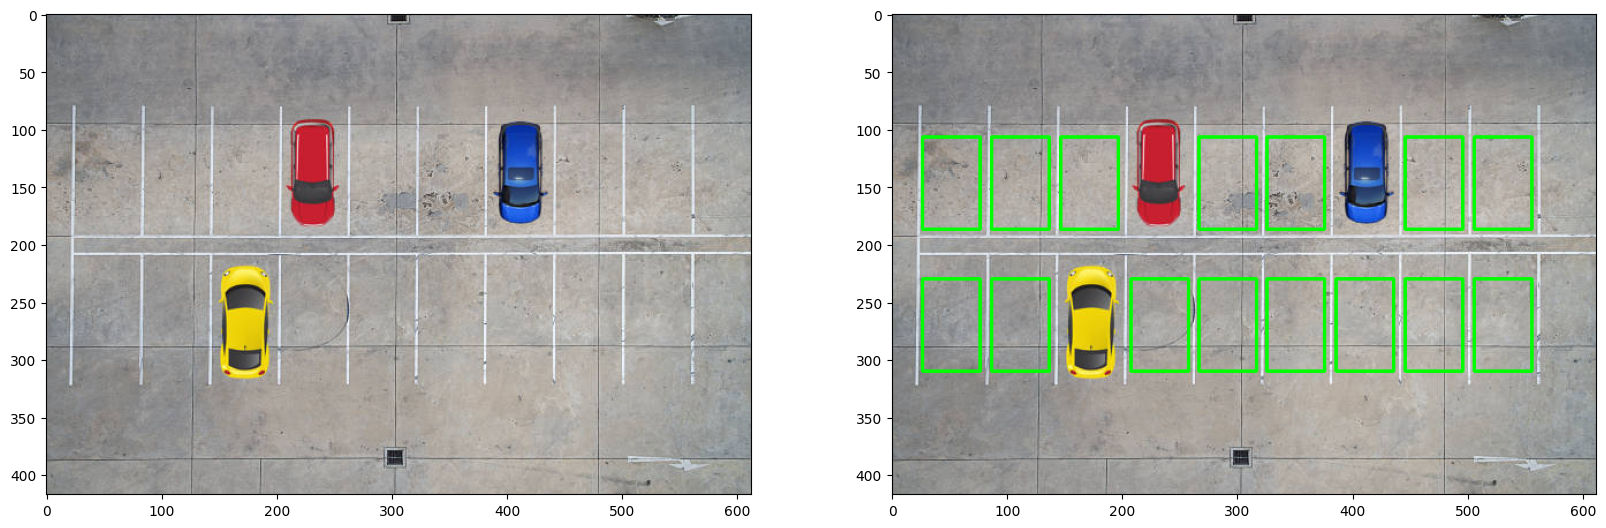

In [58]:
# make rectangle given centre coordinates
def make_rectangle(image, y, x, height = 25, width = 40):
    img = image.copy()
    img = cv2.rectangle(img, (x-height,y-width), (x+height,y+width), (0,255,0), 2)
    return img

sampleOut1 = src_occupied.copy()

for y,x in empty_coord:
    sampleOut1 = make_rectangle(sampleOut1, y, x)
cv2. imwrite(os. path. join('../data/outs/' , 'sampleOutput1.jpg'), sampleOut1)


print("Number of empty spots: ", count)
plt.figure(figsize = (20,10))
plt.subplot(121)
plt.imshow(src_occupied)
plt.subplot(122)
plt.imshow(sampleOut1)

### Pipeline

In [59]:

def detect_empty(src_occupied, src_unoccupied, thresh, slant):
    plt.figure(figsize = (50,40))
    occupied = src_occupied.copy()
    unoccupied = src_unoccupied.copy()
    # convert to grayscale
    occupied = cv2.cvtColor(occupied, cv2.COLOR_BGR2GRAY)
    unoccupied = cv2.cvtColor(unoccupied, cv2.COLOR_BGR2GRAY)
    occupied = cv2.GaussianBlur(occupied,(9,9),0)
    unoccupied = cv2.dilate(unoccupied, np.ones((5,5), np.uint8), iterations=1)
    unoccupied = cv2.GaussianBlur(unoccupied,(5,5),0)
    plt.subplot(521)
    plt.imshow(occupied, cmap='gray')
    plt.subplot(522)
    plt.imshow(unoccupied, cmap='gray')
    
    # convert to binary image
    ret, unoccupied_bin = cv2.threshold(unoccupied, thresh, 255, cv2.THRESH_BINARY)
  
    occupied = cv2.Canny(occupied, 50, 150)
    unoccupied = cv2.Canny(unoccupied, 50, 150)
    plt.subplot(523)
    plt.imshow(occupied, cmap='gray')
    plt.subplot(524)
    plt.imshow(unoccupied, cmap='gray')
    
    unoccupied_cpy = detectHoughLines(unoccupied, unoccupied_bin)
    originalLines = detectHoughLines(unoccupied, src_unoccupied)
    skel1 = skeletonize(unoccupied_cpy)
    res1 = detectHoughLines(skel1, unoccupied_bin)
    skel = skeletonize(res1)
    cnts = cv2.findContours(skel, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    src = skel.copy()
    for c in cnts:
     cv2.drawContours(src,[c], 0, (255,255,255), 3)
    res = detectHoughLines(src, skel)
    plt.subplot(525)
    plt.imshow(originalLines)
    plt.subplot(526)
    plt.imshow(skel1, cmap='gray')
    
    skel = skeletonize(res)
    res = detectHoughLines(src, skel)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    eroded = cv2.erode(res,element)
    eroded = cv2.erode(eroded,element)
    plt.subplot(527)
    plt.imshow(eroded, cmap='gray')
    plt.subplot(528)
    
    skel = skeletonize(eroded)
    plt.imshow(skel, cmap='gray')
    
    kernel = np.ones((5,5),np.uint8)
    closing = cv2.morphologyEx(occupied, cv2.MORPH_CLOSE, kernel)
    thresh = cv2.threshold(closing, 127, 255, cv2.THRESH_BINARY)[1]
    im_floodfill = thresh.copy()
    h, w = thresh.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 255)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_floodfill_inv = cv2.dilate(im_floodfill_inv, np.ones((5,5), np.uint8), iterations=1)
    
    plt.subplot(529)
    plt.imshow(im_floodfill_inv, cmap='gray')
    # bitwise or of the two images
    fin = cv2.bitwise_or(im_floodfill_inv, skel)
    plt.subplot(5,2,10)
    plt.imshow(fin, cmap='gray')
    if(slant=="false"):
      count = 0
      coords = findPKLots(skel, src_unoccupied)
      # print(len(coords))
      empty_coord = []
      for x in coords:
          if not is_Car(fin, int(x[1]), int(x[0])):
            count+=1
            empty_coord.append((int(x[1]),int(x[0])))

      final = src_occupied.copy()

      for y,x in empty_coord:
        final = make_rectangle(final, y, x)

      print("Number of empty spots: ", count)
      return final
    else: return fin



## Some More examples

### TestCase 2

##### Image contains a parking lot with **shadow**

18
Number of empty spots:  17


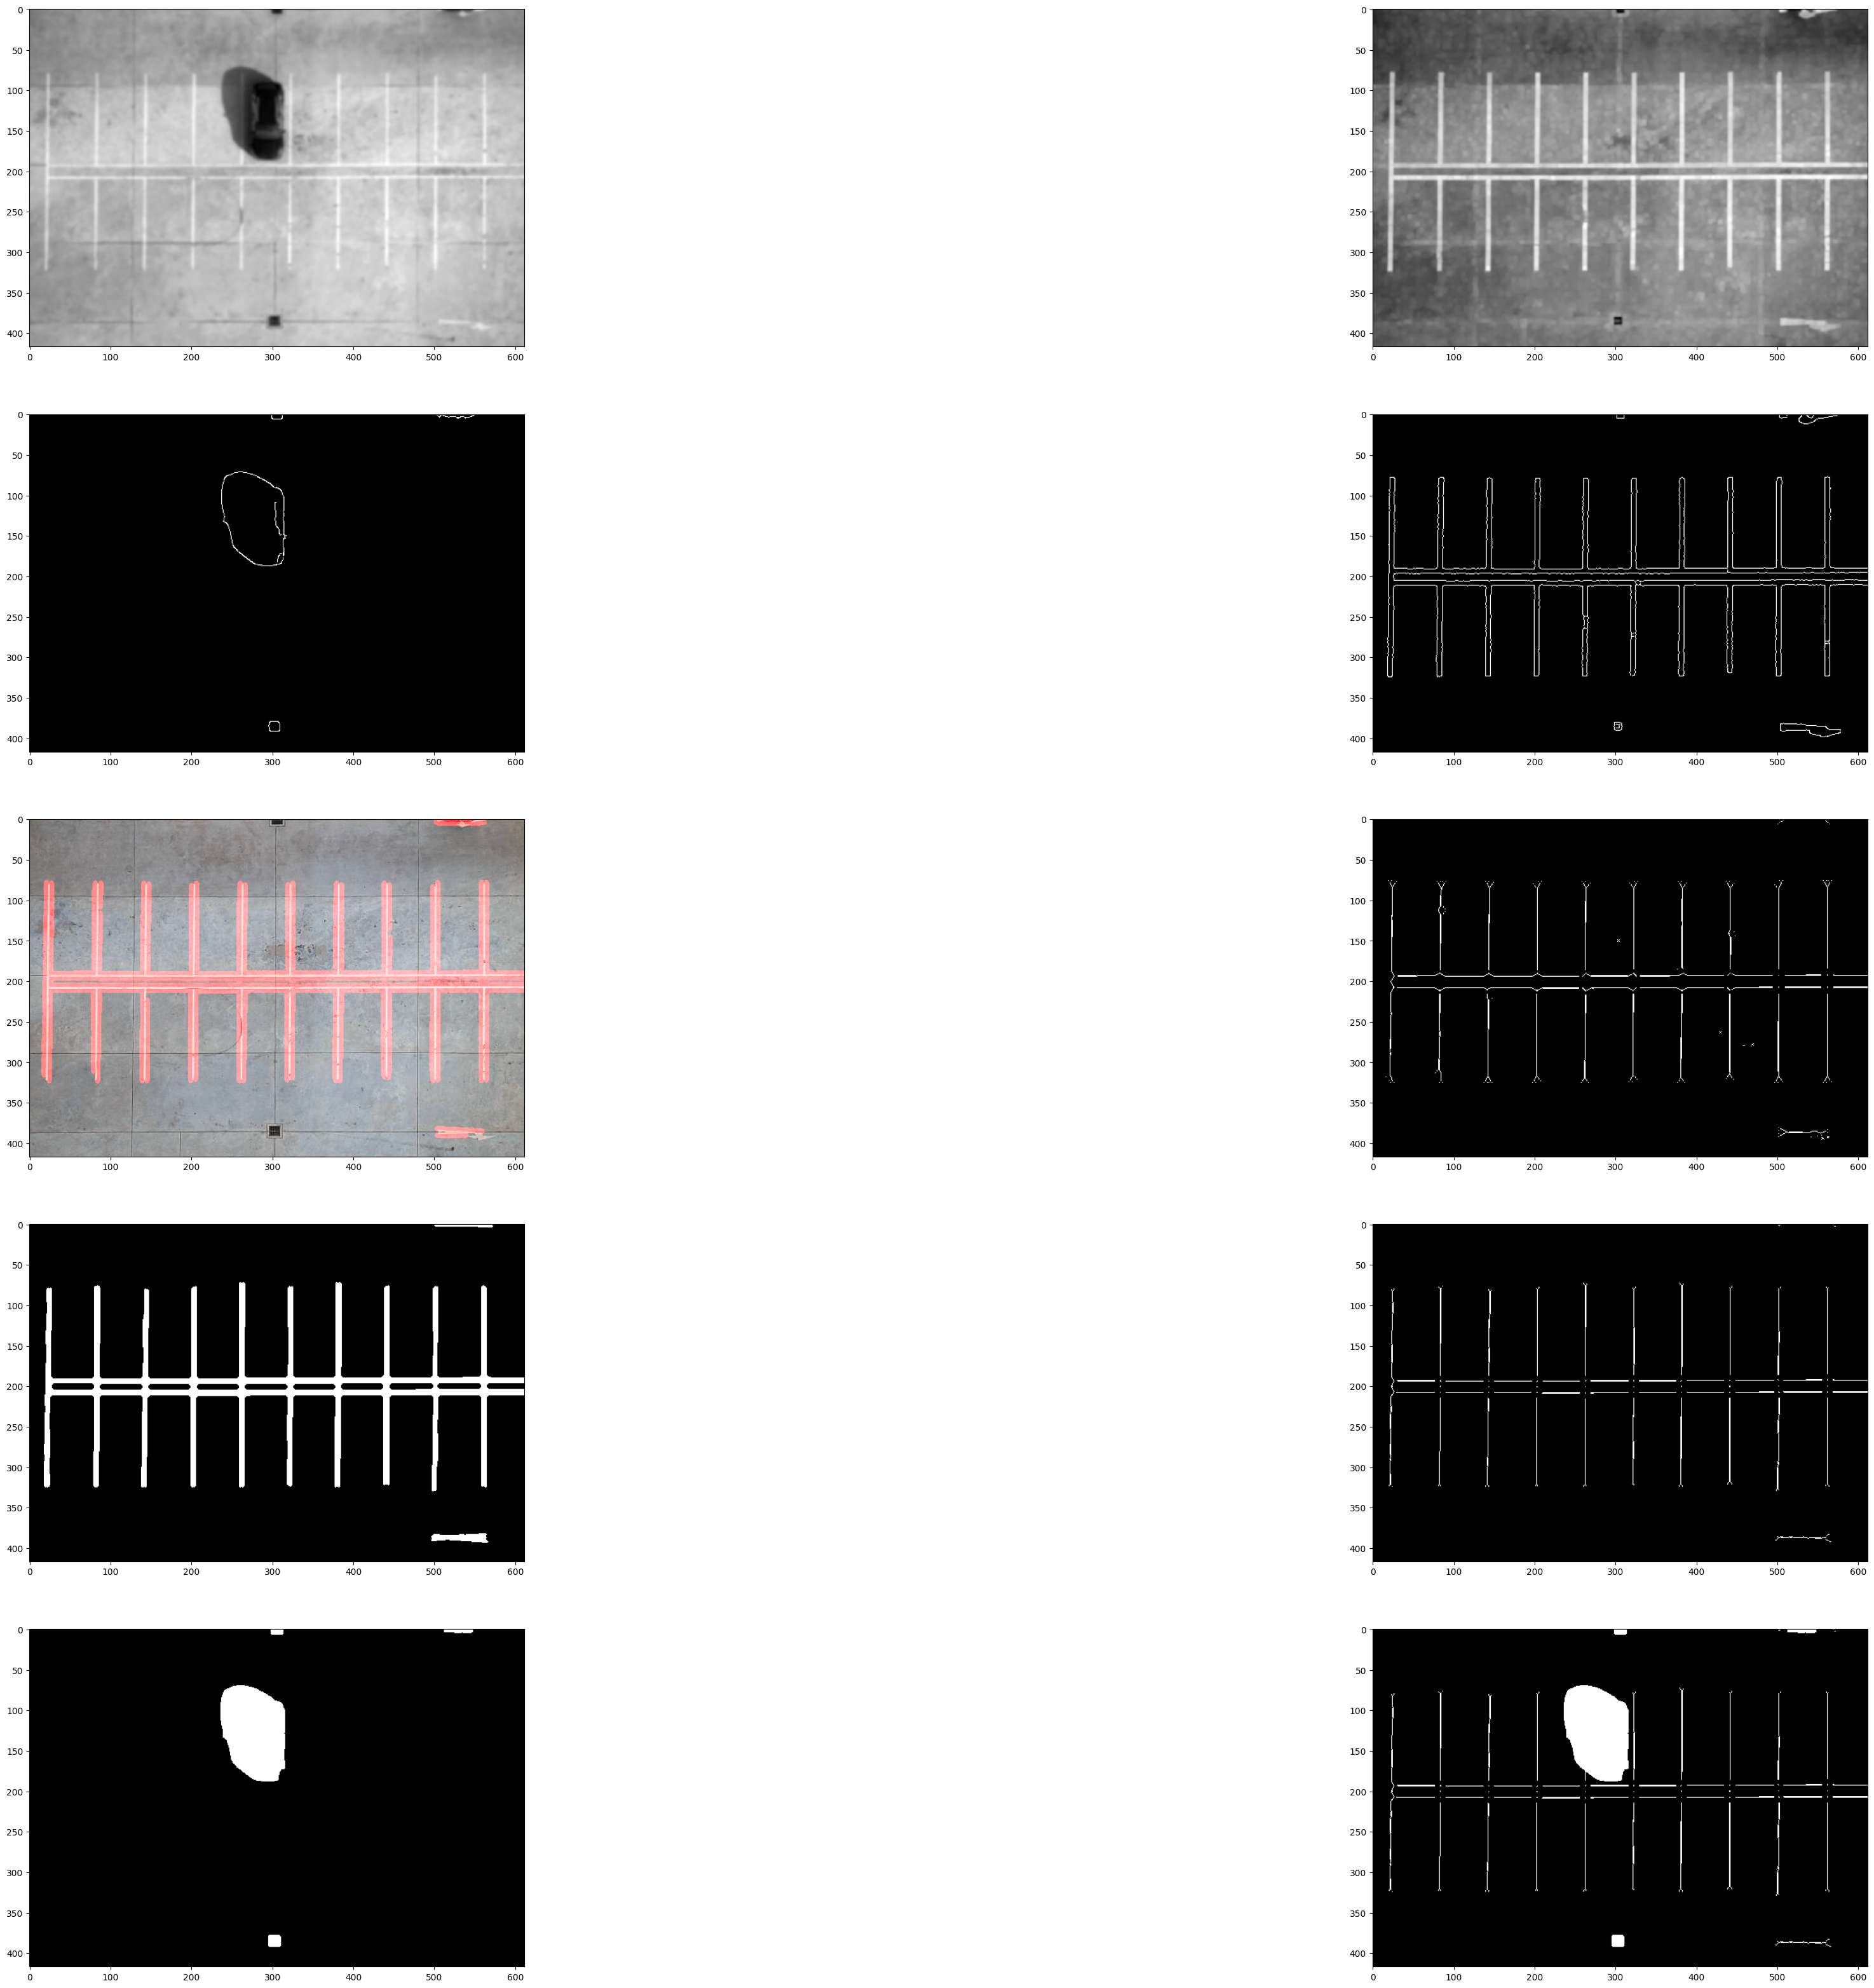

In [60]:
occ2 = cv2.imread('../data/inputs/occupied2.jpg')
unocc2 = cv2.imread('../data/inputs/empty2.jpeg')
# resize occ2 to match unocc2
occ2 = cv2.resize(occ2, (unocc2.shape[1], unocc2.shape[0]))
res = detect_empty(occ2, unocc2, 207, "false")




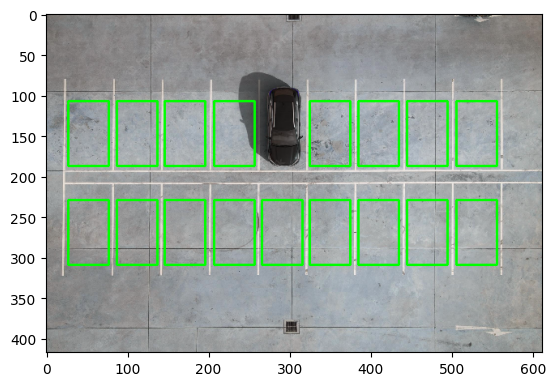

In [61]:
plt.imshow(res)

### Testcase 3 

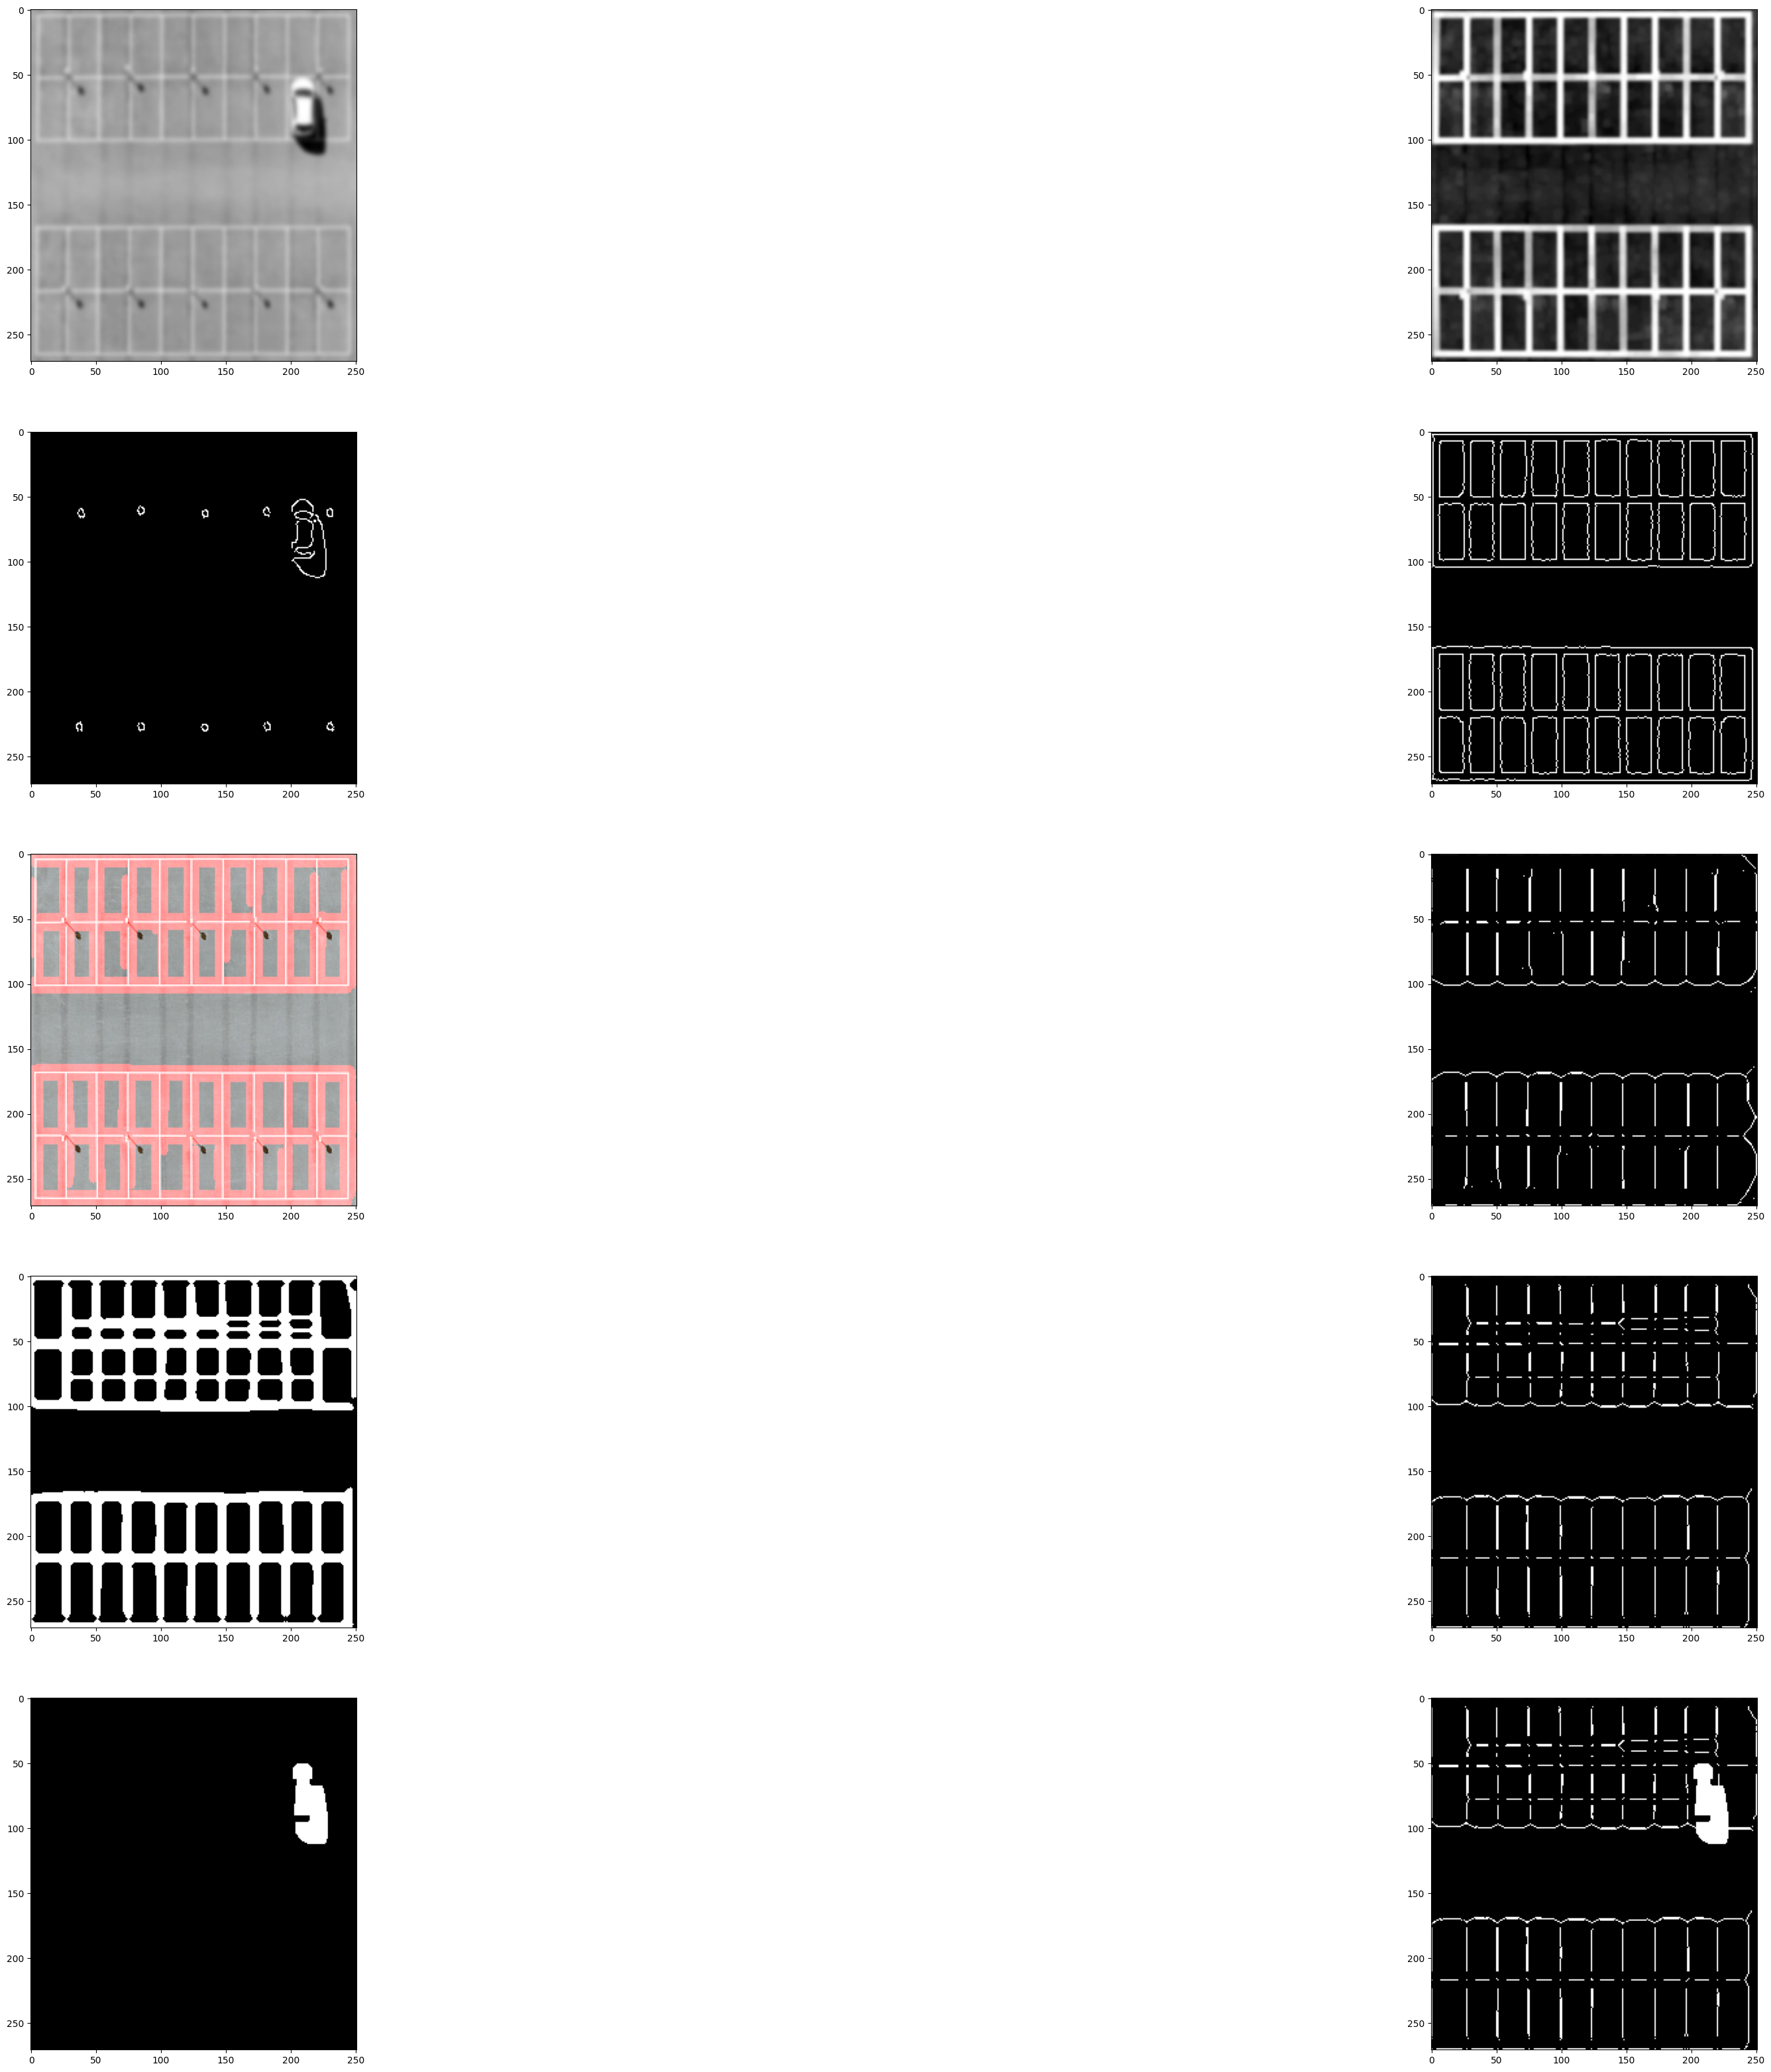

In [62]:
occ2 = cv2.imread('../data/inputs/occupied4.jpg')
unocc2 = cv2.imread('../data/inputs/unoccupied4.jpg')
# resize occ2 to match unocc2
occ2 = cv2.resize(occ2, (unocc2.shape[1], unocc2.shape[0]))
res = detect_empty(occ2, unocc2, 207, "true")

Number of empty spots:  39


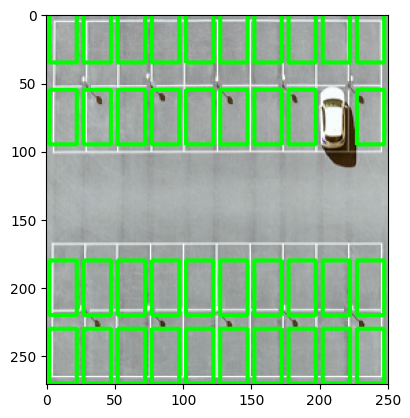

In [63]:
count = 0

centres_y = [15, 75,200, 250]
centres_x = [12.5, 12.5*3, 12.5*5, 12.5*7, 12.5*9, 12.5*11, 12.5*13, 12.5*15 , 12.5*17, 12.5*19]
empty_coord = []
for y in centres_y:
    for x in centres_x:
        if not is_Car(res, y, int(x)):
           count+=1
           empty_coord.append((y,int(x)))

final = occ2.copy()
# print(empty_coord)
for y,x in empty_coord:
    final = make_rectangle(final, y, x, 10 , 20)

plt.imshow(final)
print("Number of empty spots: ", count)

### Testcase 4

##### parking lot with **slanting** parking lines instead of straight

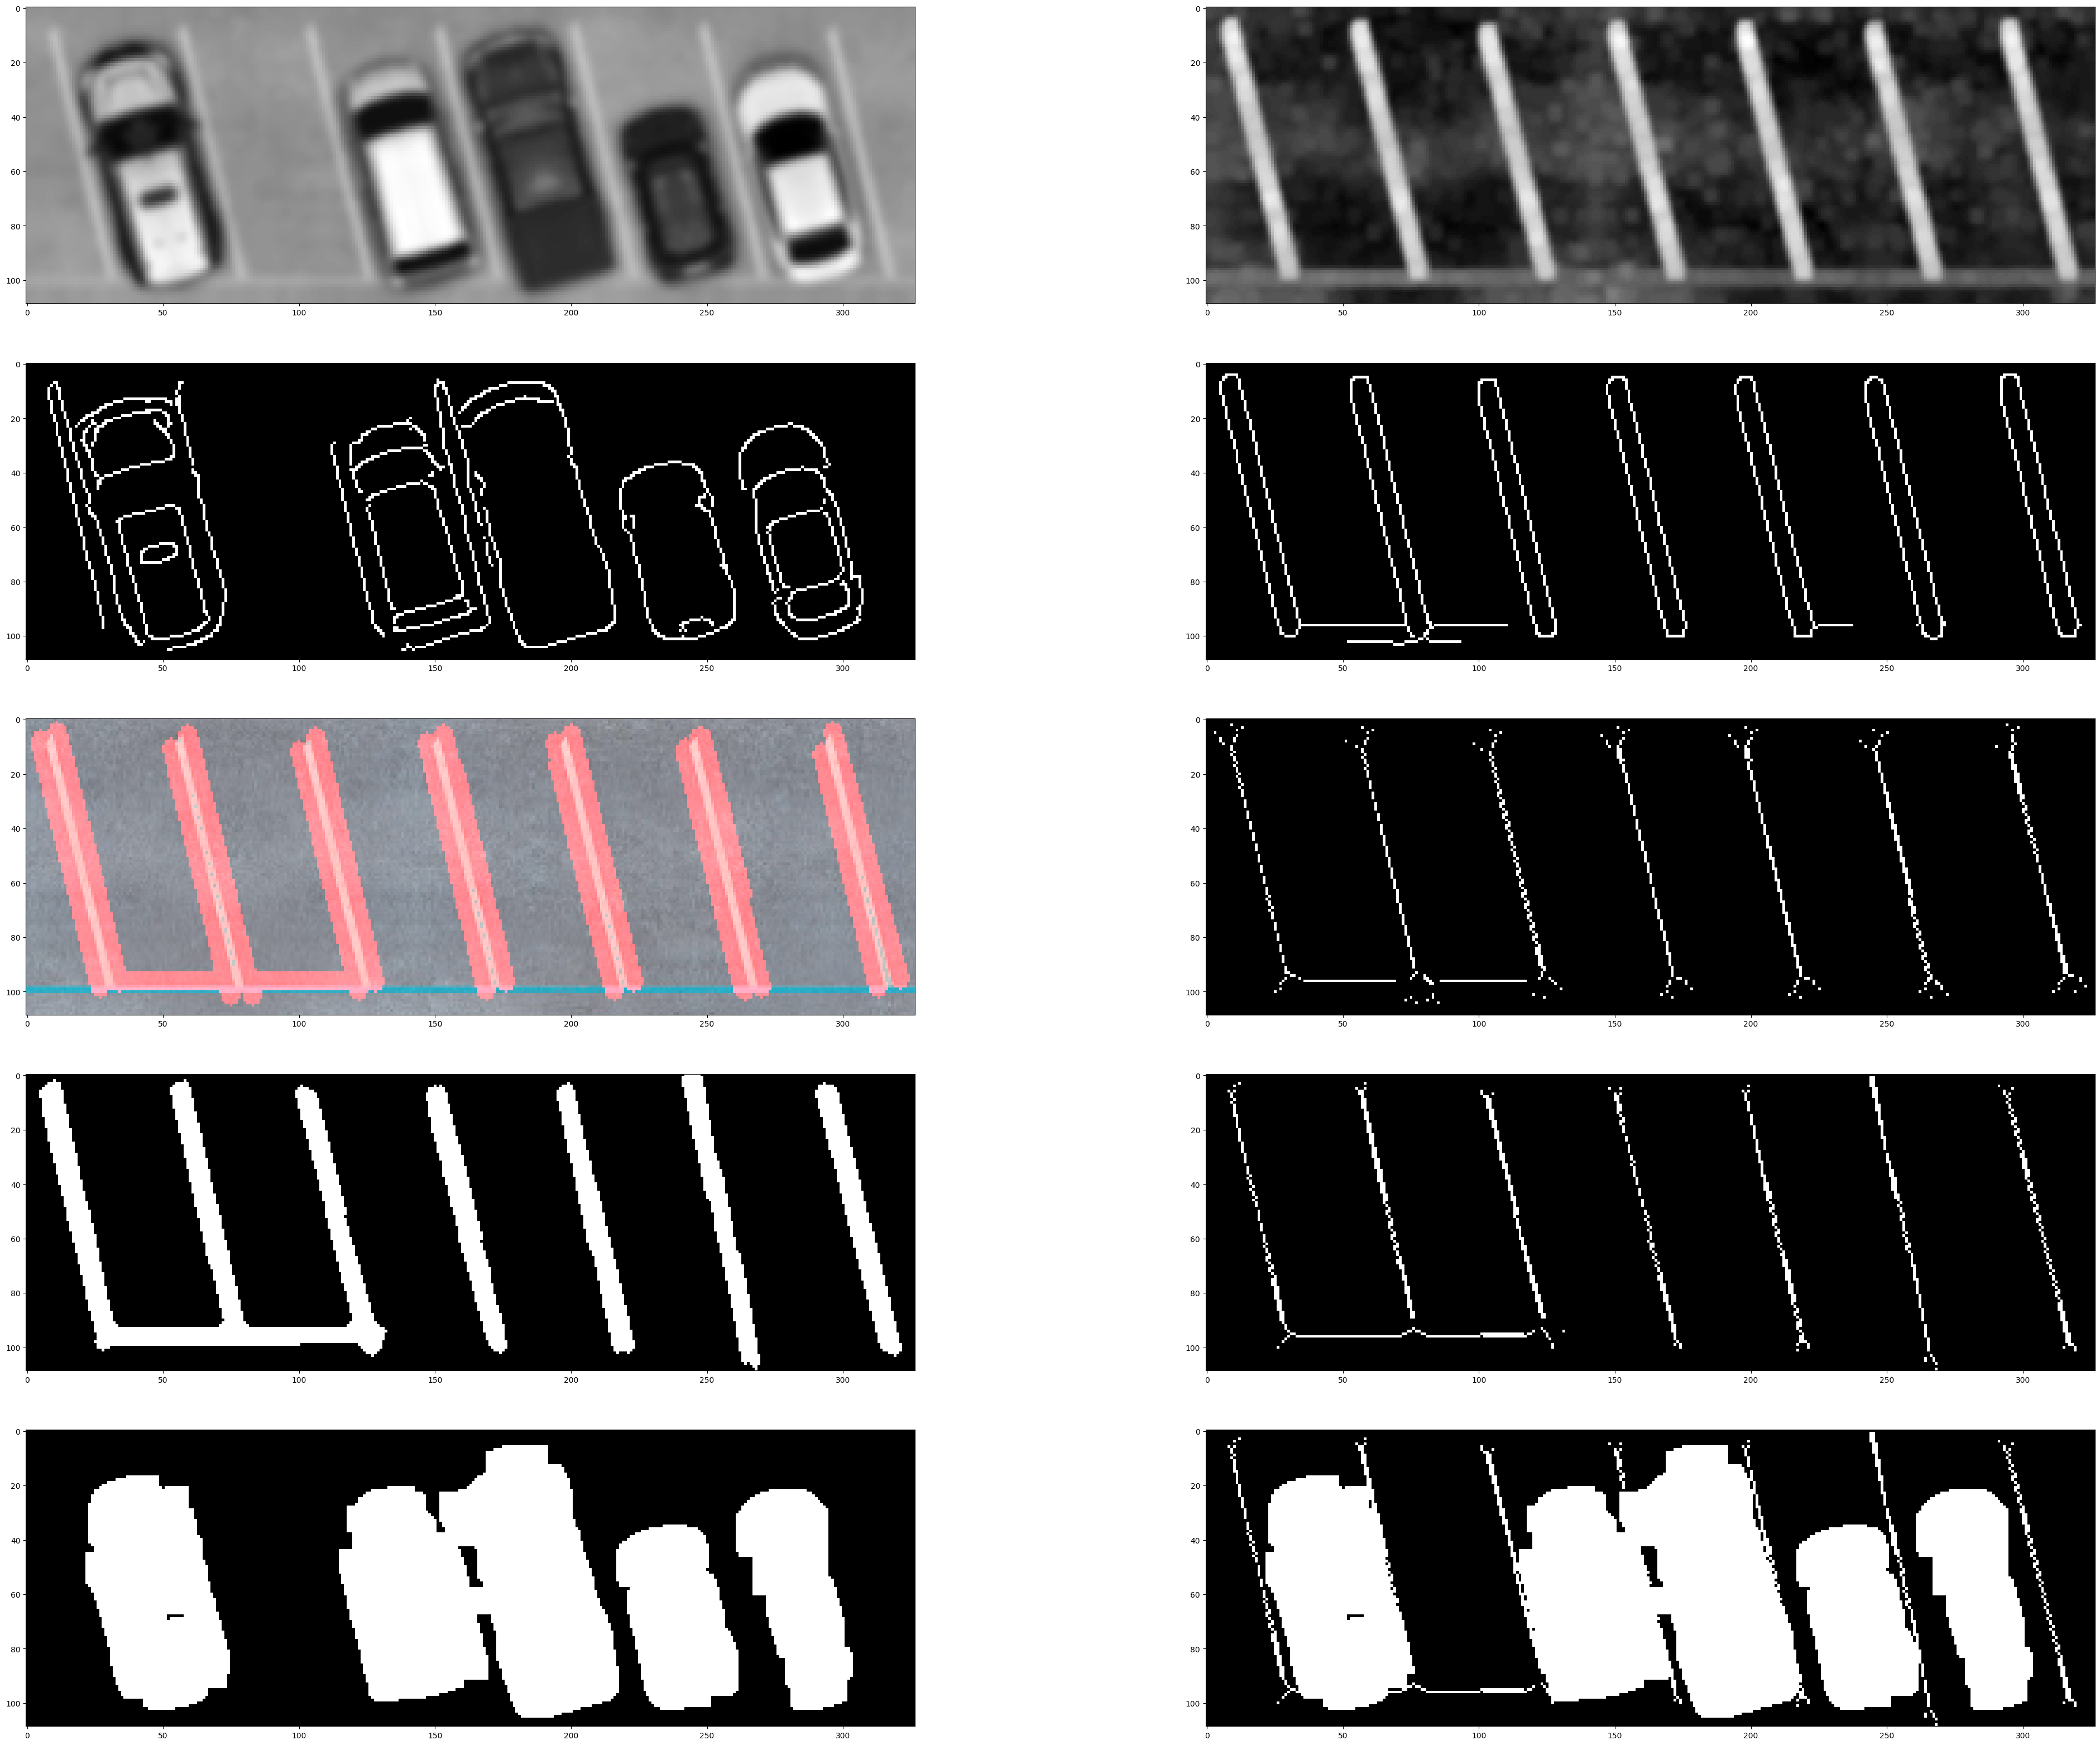

In [64]:
occ3 = cv2.imread('../data/inputs/occupied5.jpg')
unocc3 = cv2.imread('../data/inputs/unoccupied5.jpg')

# resize unocc to match occ
unocc3 = cv2.resize(unocc3, (occ3.shape[1], occ3.shape[0]))

res3 = detect_empty(occ3, unocc3, 180, "true")

Number of empty spots:  1


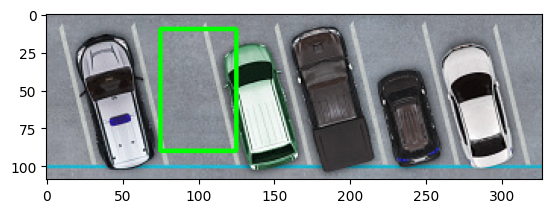

In [65]:
count = 0

centres_y = [50]
centres_x = [50,100,150,200,245,290]
empty_coord = []
for y in centres_y:
    for x in centres_x:
        if not is_Car(res3, y, x):
           count+=1
           empty_coord.append((y,x))

final = occ3.copy()

for y,x in empty_coord:
    final = make_rectangle(final, y, x)

plt.imshow(final)
print("Number of empty spots: ", count)

### Testcase 5

##### a different unoccupied parking lot and corresponding occupied parking lot

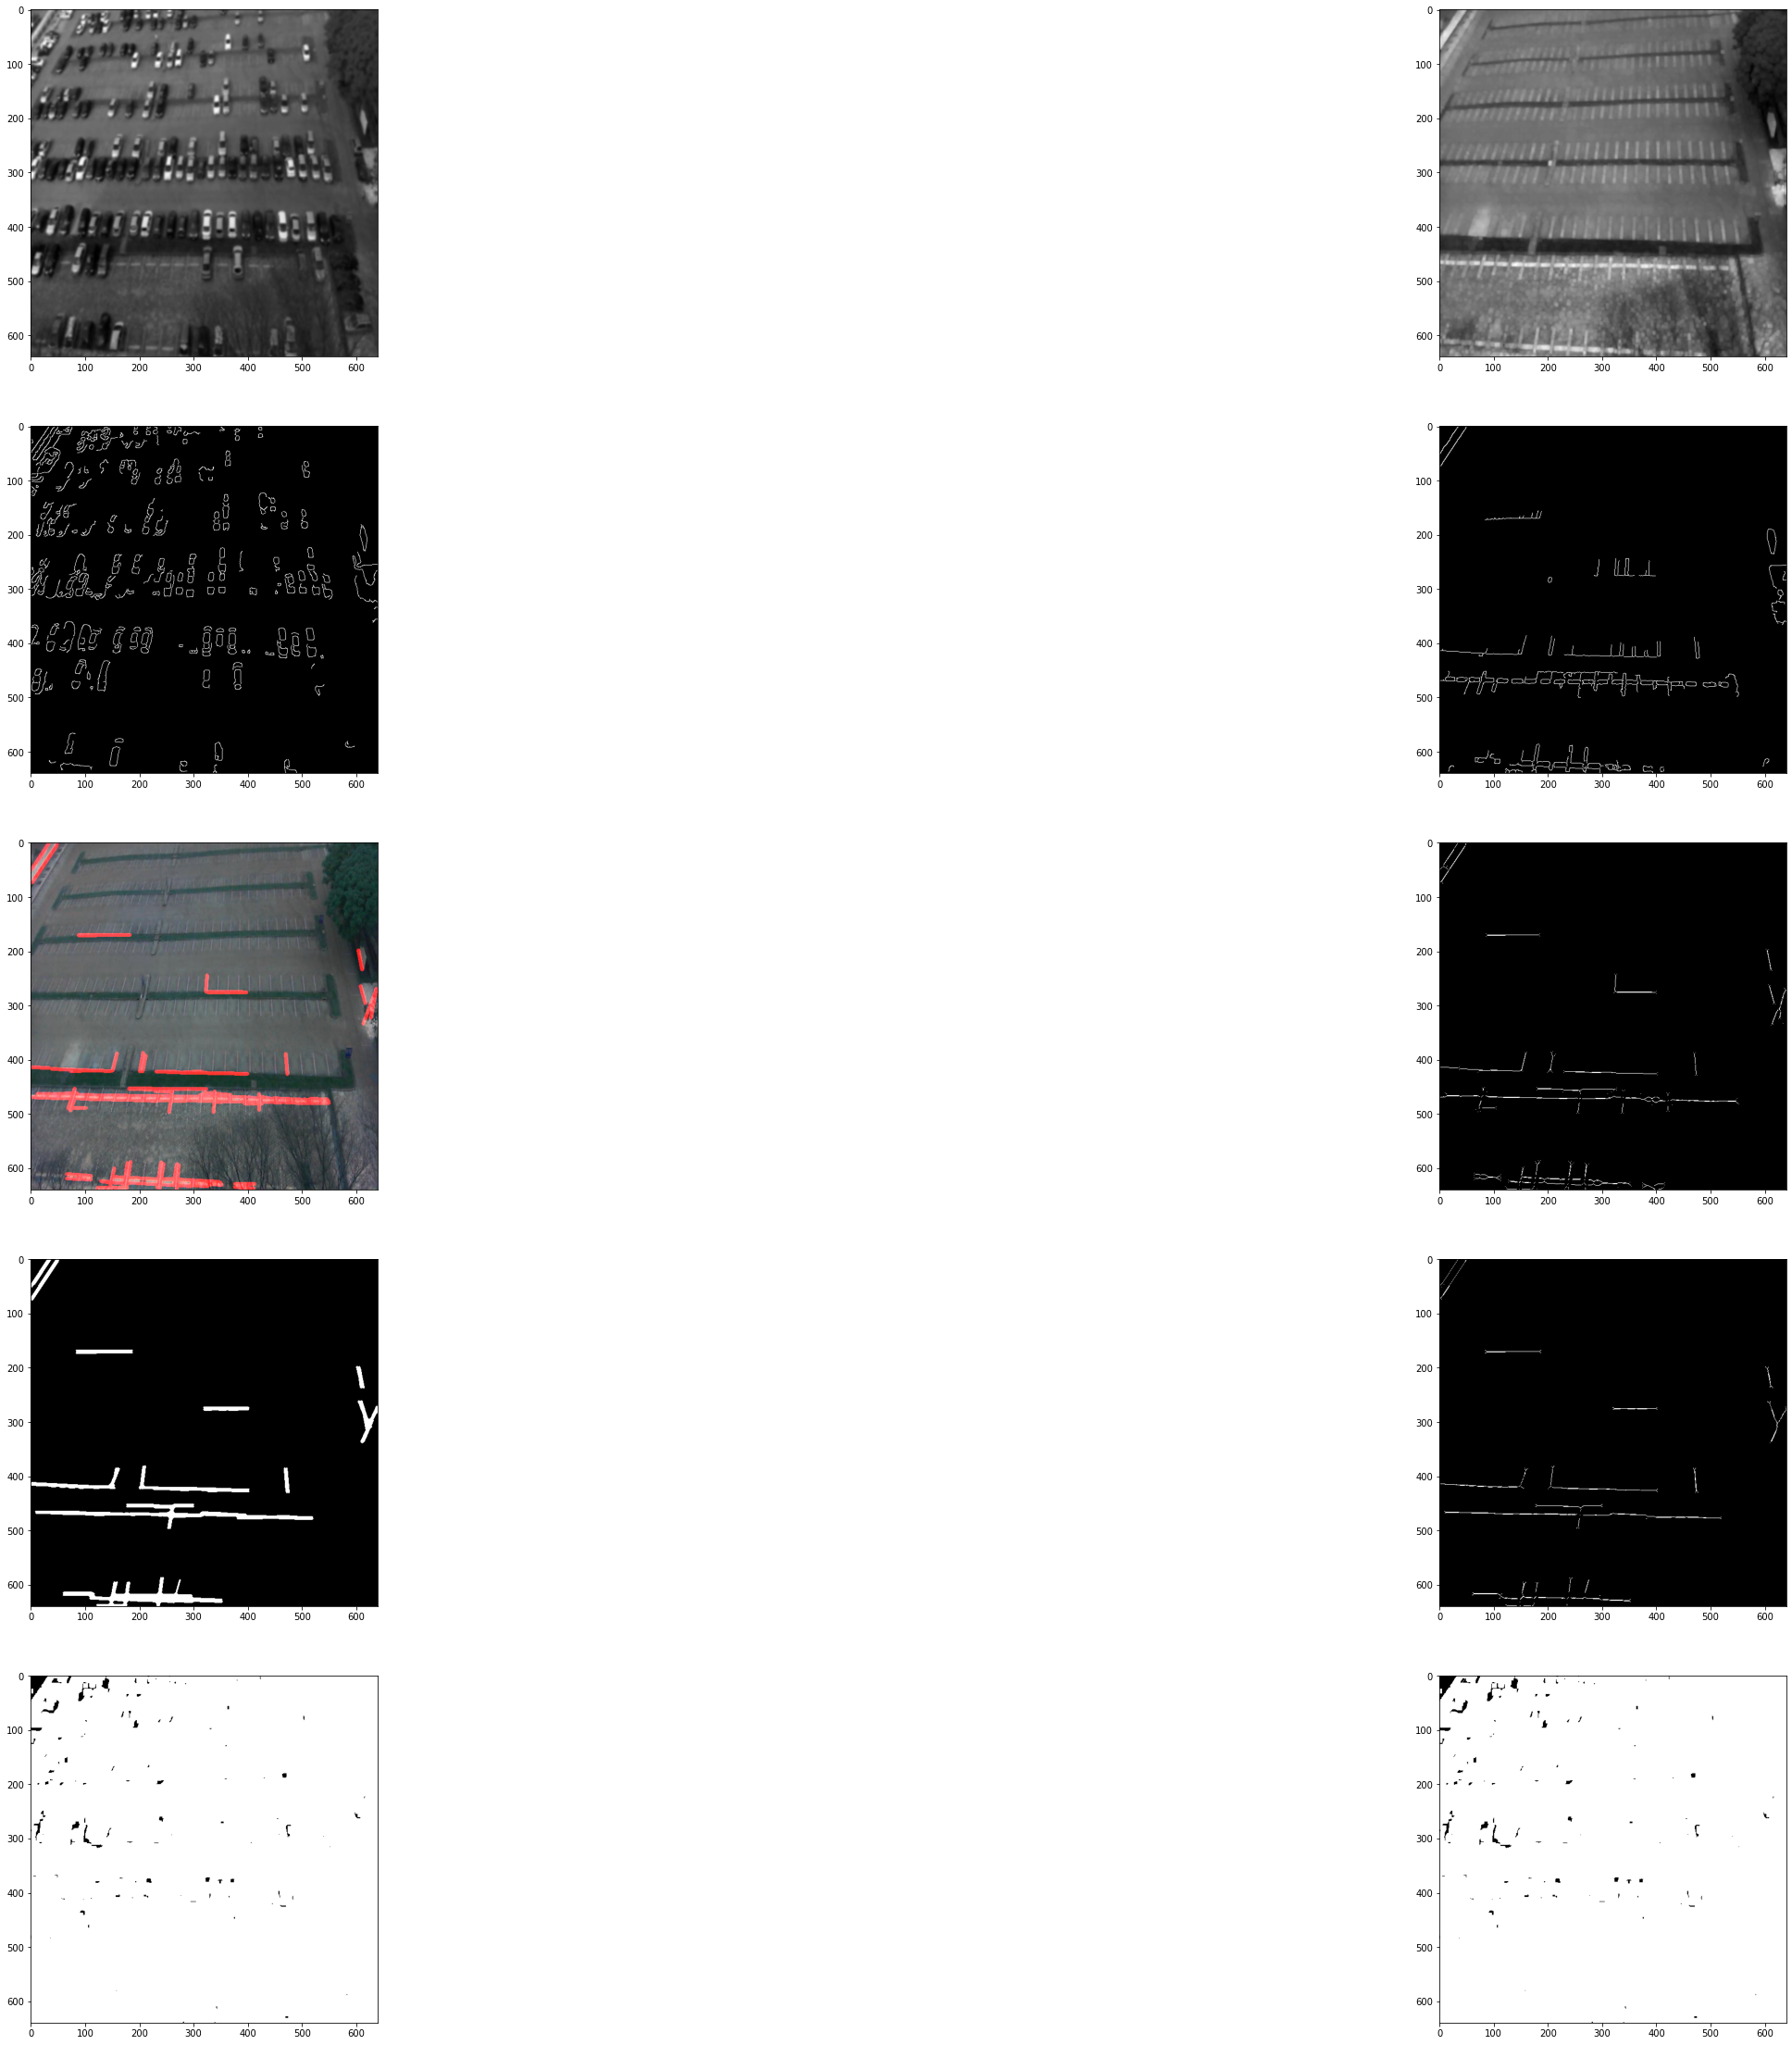

In [304]:
occ3 = cv2.imread('../data/inputs/occupied.jpg')
unocc3 = cv2.imread('../data/inputs/empty.jpg')
# resize unocc to match occ
unocc3 = cv2.resize(unocc3, (occ3.shape[1], occ3.shape[0]))

res3 = detect_empty(occ3, unocc3, 180, "true")


- This image is from the carpk dataset, our approach does not work because it is specifically for top view of parking lots.
- Also, the parking lines are very faint and thus we were unable to detect the parking lot lines using houghlines transform